## Imports

In [114]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplfinance as mpf
import Data_for_bp as dfb
import time
from numba import jit
import timeit

## read data

In [2]:
df = pd.read_pickle('Data for Practicum 2/ticks_2019.pkl')

In [3]:
df.columns

Index(['EURUSD.bid', 'EURUSD.ask', 'EURUSD.mid'], dtype='object')

## Data Analysis

In [4]:
time_deltas = df.index.to_series().diff()

In [5]:
def tick_data_describe(df):
    time_deltas = df.index.to_series().diff()
    price_deltas = df['EURUSD.mid'].diff()
    spread = df['EURUSD.ask'] - df['EURUSD.bid']
    summary_data = {
        'Description': [
            'Number of ticks',
            'Mean time between ticks',
            'Median time between ticks',
            'Max time between ticks',
            'Min time between ticks',
            'Ticks with time delta > 10 minutes',
            'Ticks with time delta > 60 seconds',
            'Ticks with time delta > 1 second',
            'Ticks with time delta > 0.1 seconds',
            'Ticks with time delta < 0.1 seconds',
            'Mean price delta',
            'Median price delta',
            'Max price delta',
            'Min price delta',
            'instances with price delta < 0.0001',
            'instances with price delta > 0.0001',
            'instances with price delta > 0.001',
            'instances with price delta > 0.01',
            'instances with price delta > 0.1',
            'Mean spread',
            'Median spread',
            'Max spread',
            'Min spread',
            'instances with spread < 0.0001',
            'instances with spread > 0.0001',
            'instances with spread > 0.001',
            'instances with spread > 0.01',
            'instances with spread > 0.1',
        ],
        'Value': [
            len(df),
            time_deltas.mean(),
            time_deltas.median(),
            time_deltas.max(),
            time_deltas.min(),
            len(time_deltas[time_deltas > pd.Timedelta(minutes=10)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=60)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=1)]),
            len(time_deltas[time_deltas > pd.Timedelta(seconds=0.1)]),
            len(time_deltas[time_deltas < pd.Timedelta(seconds=0.1)]),
            price_deltas.mean(),
            price_deltas.median(),
            price_deltas.max(),
            price_deltas.min(),
            price_deltas[price_deltas < 0.0001].count(),
            price_deltas[price_deltas > 0.0001].count(),
            price_deltas[price_deltas > 0.001].count(),
            price_deltas[price_deltas > 0.01].count(),
            price_deltas[price_deltas > 0.1].count(),
            spread.mean(),
            spread.median(),
            spread.max(),
            spread.min(),
            spread[spread < 0.0001].count(),
            spread[spread > 0.0001].count(),
            spread[spread > 0.001].count(),
            spread[spread > 0.01].count(),
            spread[spread > 0.1].count(),
        ]
    }

    summary_df = pd.DataFrame(summary_data)
    fig, ax = plt.subplots(figsize=(10, 3))  # set the size
    ax.axis('off')
    ax.table(cellText=summary_df.values, colLabels=summary_df.columns, cellLoc = 'center',loc='center')
    plt.show()


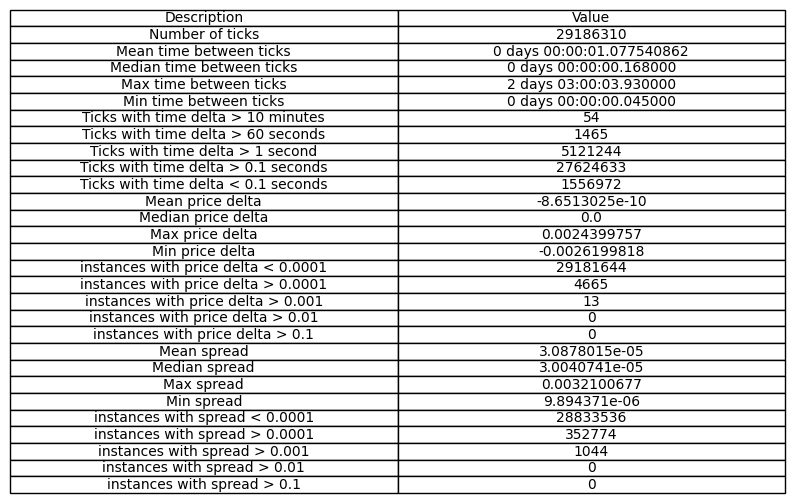

In [6]:
tick_data_describe(df)

In [7]:
ohlc = dfb.tick_to_ohlc(df, '1D')

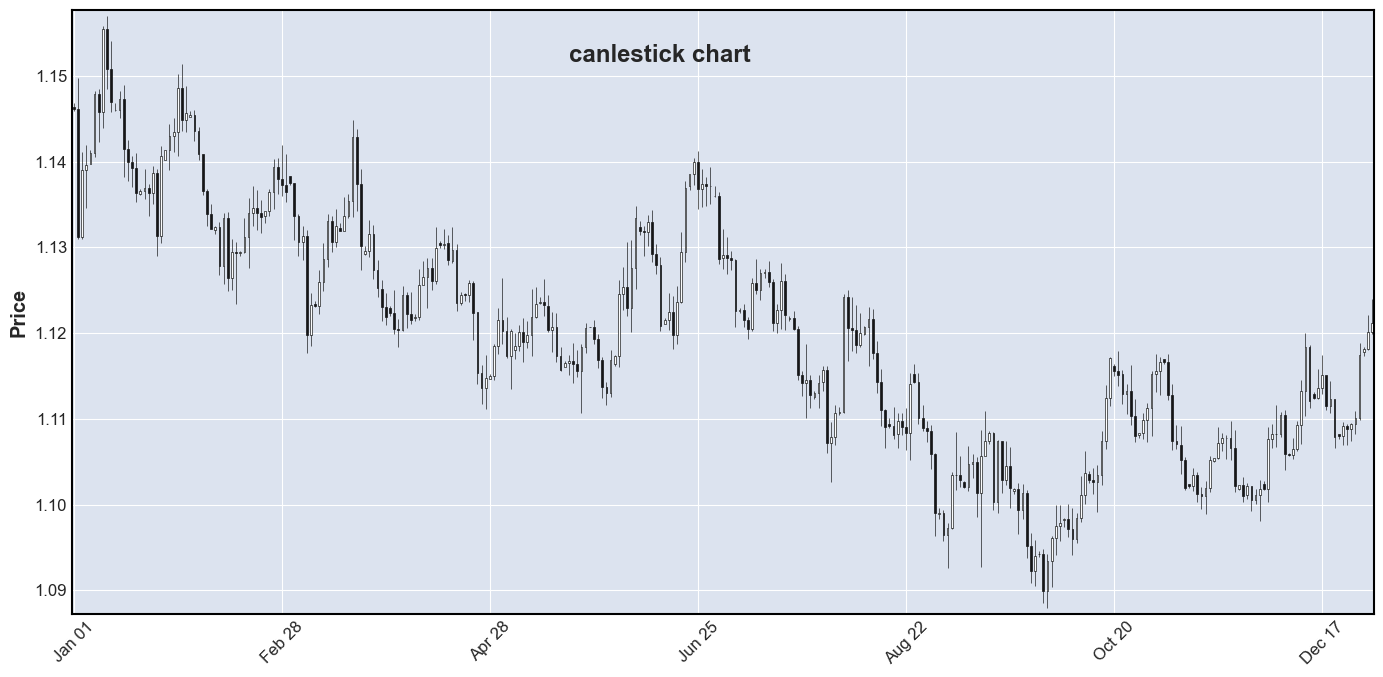

In [8]:
dfb.plot_data(ohlc)

In [9]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    daily_volatility = ohlc['returns'].std()
    buy_and_hold_return = (ohlc['returns']+1).prod()
    mean_return = ohlc['returns'].mean()
    

In [10]:
def ohlc_stats(ohlc):
    ohlc['returns'] = ohlc['close'].pct_change()
    ohlc['daily_returns'] = (ohlc['close']-ohlc['open'])/ohlc['open']
    fig,axs = plt.subplots(3,1,figsize=(10,10))
    axs[0].plot(ohlc['returns'])
    axs[1].hist(ohlc['returns'],bins=20)

    daily_volatility = ohlc['returns'].std()*np.sqrt(252)*100
    buy_and_hold_return = ((ohlc['returns']+1).prod() - 1)*100  # Adjusting to get the total return
    mean_return = ohlc['returns'].mean()*100

    stats_data = {
        'Description': [
            'Daily Volatility',
            'Buy and Hold Return',
            'Mean Return'
        ],
        'Value': [
            daily_volatility,
            buy_and_hold_return,
            mean_return
        ]
    }
    
    stats_df = pd.DataFrame(stats_data)
    axs[2].axis('off')
    axs[2].table(cellText=stats_df.values, colLabels=stats_df.columns, cellLoc = 'center',loc='center')
    fig.tight_layout()
    plt.show()


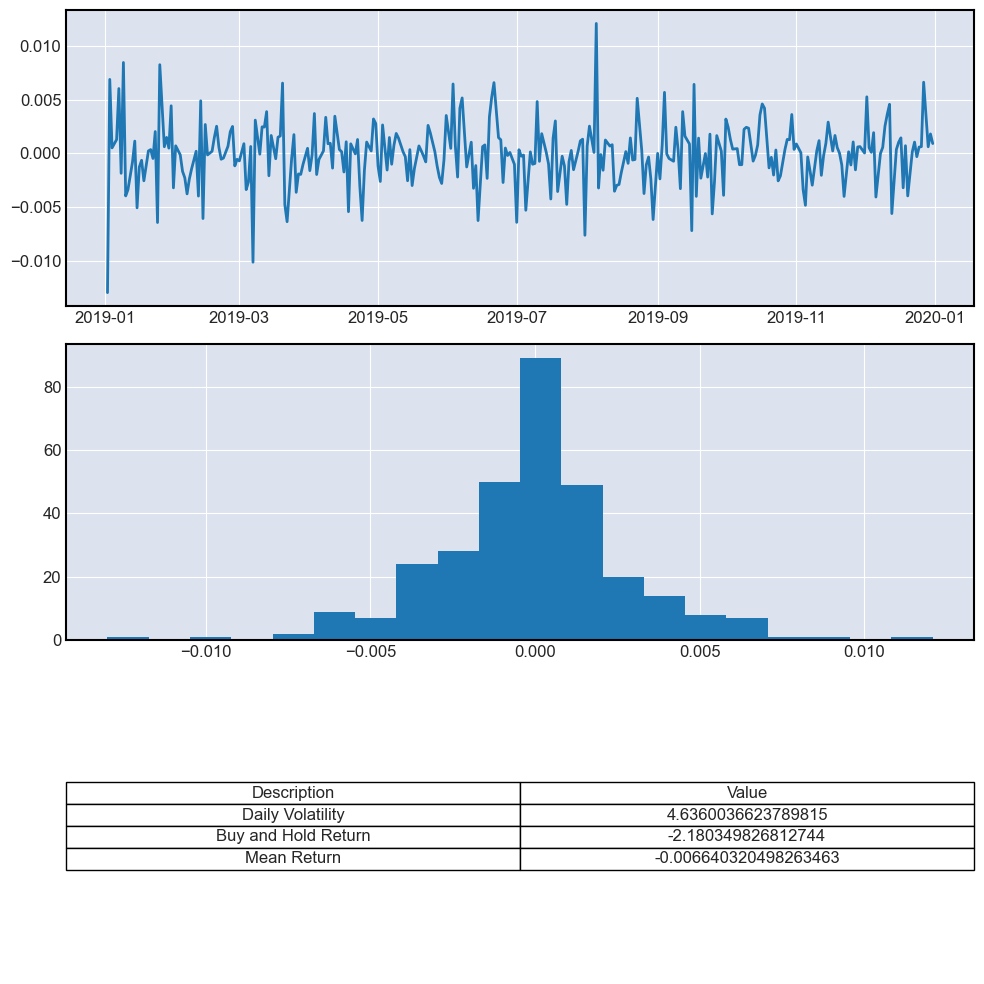

In [11]:
ohlc_stats(ohlc)

In [12]:
def data_analysis_for_bp(tick_data_file):
    df = pd.read_pickle(tick_data_file)
    tick_data_describe(df)
    ohlc = dfb.tick_to_ohlc(df, '1D')
    dfb.plot_data(ohlc)
    ohlc_stats(ohlc)

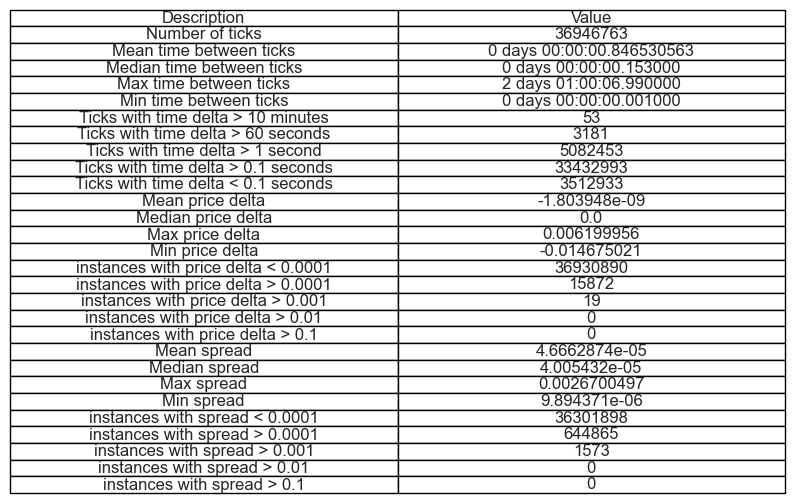

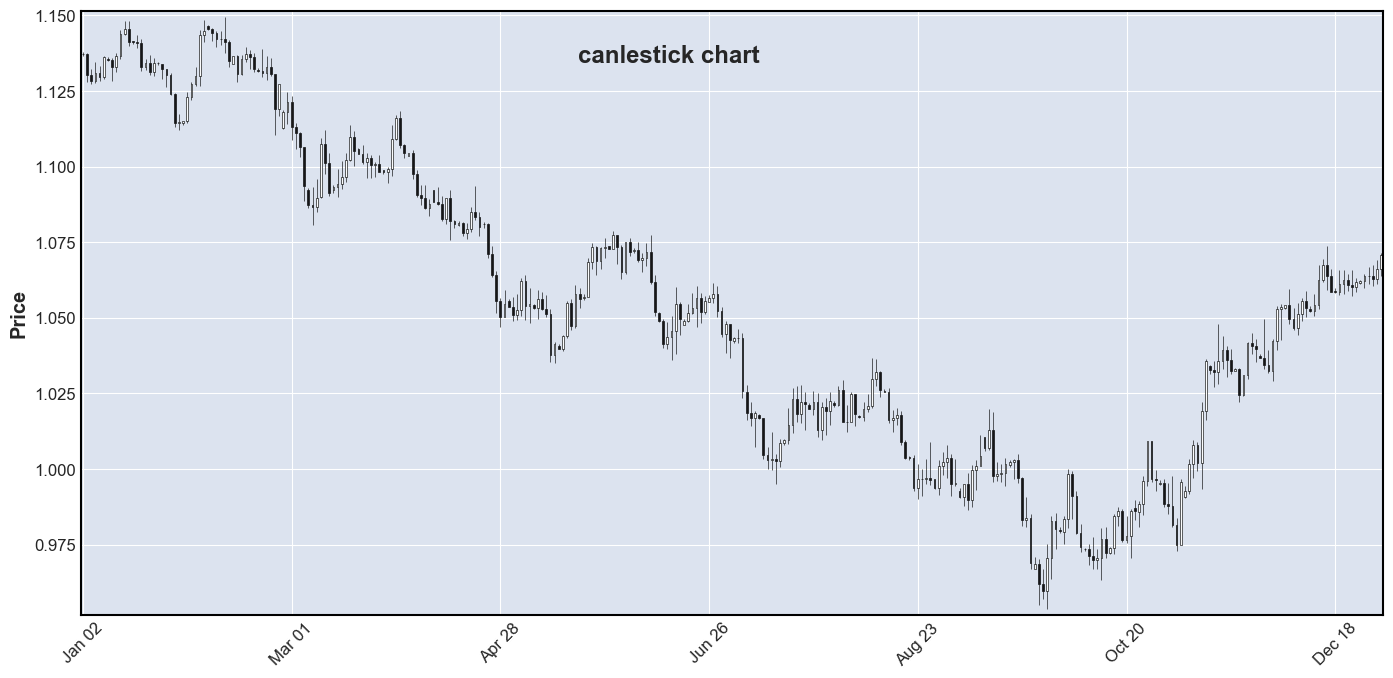

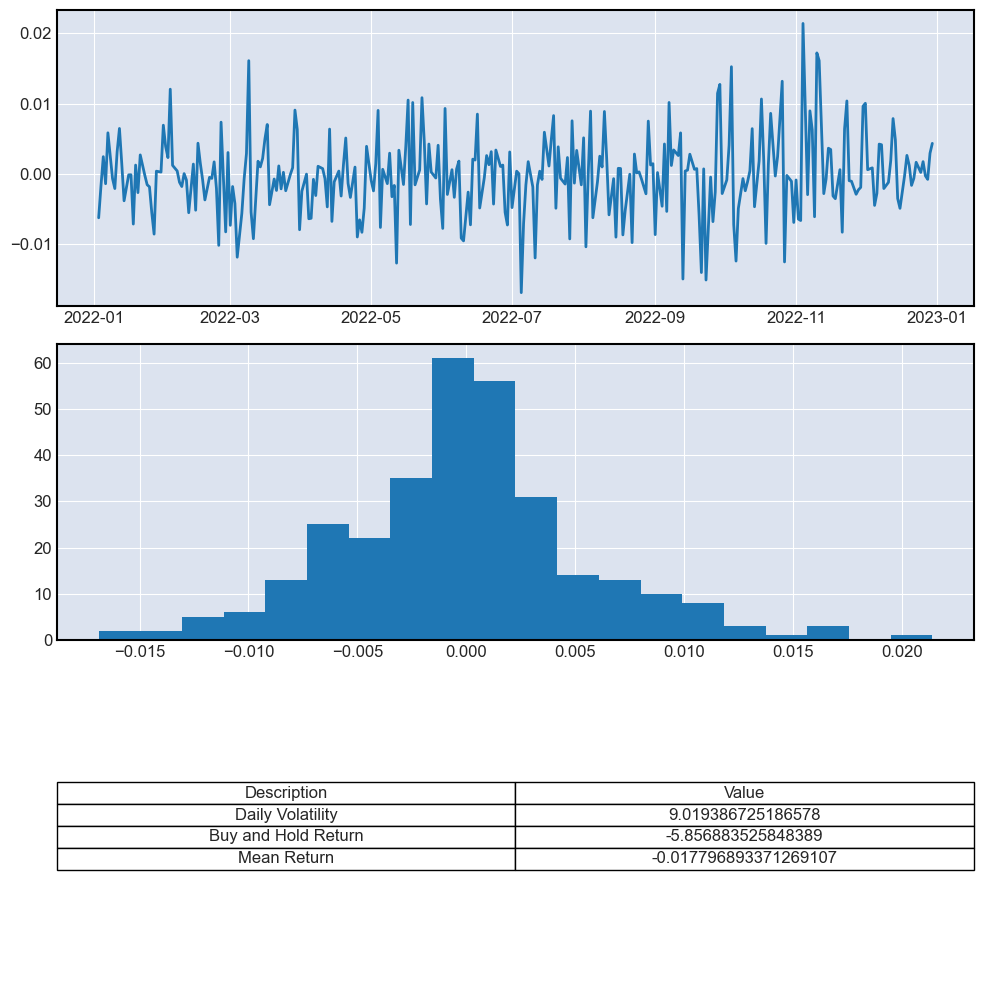

In [13]:
data_analysis_for_bp('Data for Practicum 2/ticks_2022.pkl')

### Optimised Data Gathering

In [14]:
# function that takes in a adate range and if across multiple years splits into year pairs.
def year_order(start_date, end_date):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    if start_date.year == end_date.year:
        return {start_date.year: [start_date, end_date]}
    else:
        year_dict = {}
        for year in range(start_date.year, end_date.year + 1):
            if year == start_date.year:
                year_dict[year] = [start_date, pd.to_datetime(str(year+1) + '-12-31')]
            elif year == end_date.year:
                year_dict[year] = [pd.to_datetime(str(year) + '-01-01'), end_date]
            else:
                year_dict[year] = [pd.to_datetime(str(year) + '-01-01'), pd.to_datetime(str(year) + '-12-31')]
        return year_dict

In [15]:
# extracts data from various files based on date range given and then returns it as a single dataframe
def data_gather_from_files(start_date,end_date,file_path='Data for Practicum 2'):
    year_dict = year_order(start_date,end_date)
    full_df = pd.DataFrame()
    for year in year_dict.keys():
        year_df = pd.read_pickle(file_path + '/ticks_' + str(year) + '.pkl')
        year_dict[year][0] = year_dict[year][0].tz_localize('UTC')
        year_dict[year][1] = year_dict[year][1].tz_localize('UTC')
        year_df = year_df.loc[year_dict[year][0]:year_dict[year][1]]
        full_df = pd.concat([full_df,year_df])
    return full_df

In [16]:
data = data_gather_from_files('27 dec 2019','3 jan 2020')

In [17]:
data

,EURUSD.bid,EURUSD.ask,EURUSD.mid
Date,,,
2019-12-27 00:00:00.443000+00:00,1.11013,1.11015,1.110140
2019-12-27 00:00:00.940000+00:00,1.11011,1.11015,1.110130
2019-12-27 00:00:02.074000+00:00,1.11011,1.11013,1.110120
2019-12-27 00:00:02.175000+00:00,1.11011,1.11014,1.110125
2019-12-27 00:00:02.378000+00:00,1.11011,1.11016,1.110135
...,...,...,...
2020-01-02 23:59:37.622000+00:00,1.11708,1.11711,1.117095
2020-01-02 23:59:39.622000+00:00,1.11708,1.11712,1.117100
2020-01-02 23:59:39.723000+00:00,1.11708,1.11711,1.117095


## Ladder strategy data engineering and strategy visualisation

### Ladderize the data

In [18]:
def ladderize_open(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    ladderized_data = [tick_data.iloc[0]]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price
    ladderized_data[-1]=tick_data.iloc[-1]
    return pd.Series(np.round(ladderized_data,4), index=tick_data.index)

In [19]:
def ladderize_absolute(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    # Initialize ladder at the nearest rounded price level based on grid size
    ladderized_data = [(tick_data.iloc[0] / grid_size).round() * grid_size]
    for i in range(1, len(tick_data)):
        if tick_data.iloc[i] > ladderized_data[-1] + grid_size:
            ladderized_data.append(ladderized_data[-1] + grid_size)
        elif tick_data.iloc[i] < ladderized_data[-1] - grid_size:
            ladderized_data.append(ladderized_data[-1] - grid_size)
        else:
            ladderized_data.append(ladderized_data[-1])
    # Adding the final close price and changing th open price
    ladderized_data[-1]=tick_data.iloc[-1]
    ladderized_data[0]=tick_data.iloc[0]
    return pd.Series(np.round(ladderized_data,4), index=tick_data.index)

In [20]:
def plot_colored_ladder(ladderized_data):
    for i in range(1, len(ladderized_data)):
        if ladderized_data[i] > ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='red')
        elif ladderized_data[i] < ladderized_data[i-1]:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='green')
        else:
            plt.plot(ladderized_data.index[i-1:i+1], ladderized_data.iloc[i-1:i+1], color='blue')  # Neutral color for no change

In [21]:

def plot_ladderized(start_date, end_date, grid_size=0.0005, ladderize_function=ladderize_open):
    # Load the tick data
    tick_data = data_gather_from_files(start_date, end_date)['EURUSD.mid']

    ladderized_data = ladderize_function(tick_data, grid_size)

    # Plot the results
    plt.figure(figsize=(15,6))
    plt.plot(tick_data, label='Tick Data',alpha=0.5)
    plot_colored_ladder(ladderized_data)
    # plt.plot(ladderized_data, label='Ladderized Data', linestyle='--')
    plt.title('Ladder Strategy Visualization for date range: {} to {}'.format(start_date, end_date))
    plt.legend()
    plt.show()



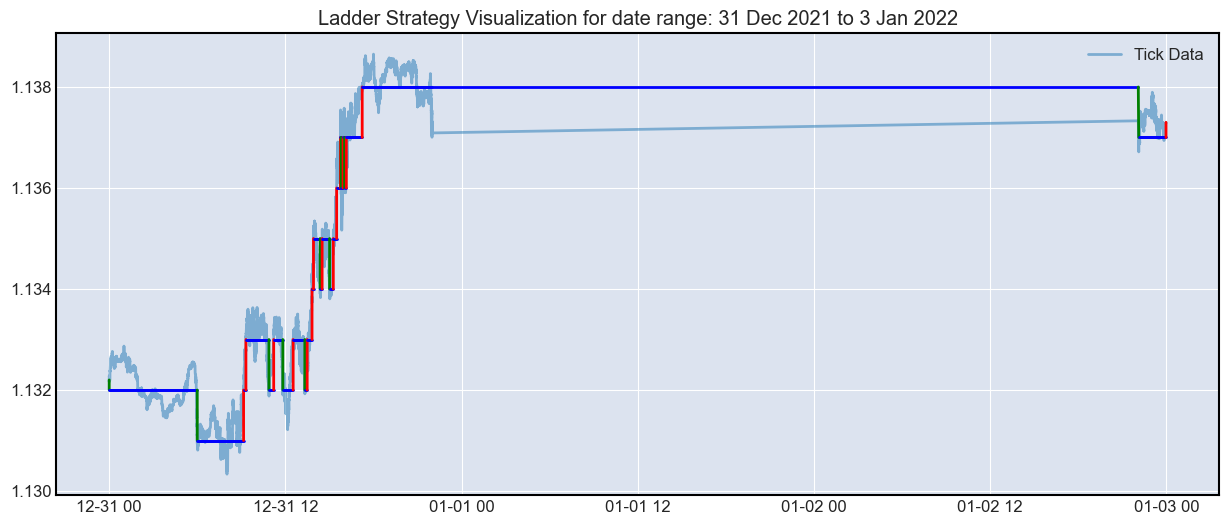

In [89]:
plot_ladderized('31 Dec 2021','3 Jan 2022',grid_size=0.001,ladderize_function=ladderize_absolute)

In [99]:
tick_data = data_gather_from_files('1 Jan 2021','31 Jul 2022')['EURUSD.mid']
for g in [0.001,0.005,0.01]:
    time1 = time.time()
    ladderized_data = ladderize_absolute(tick_data, grid_size=g)
    time2 = time.time()
    print('ladderize_absolute for g = ',g,': ',time2-time1)

    time1 = time.time()
    ladderized_data = ladderize_open(tick_data, grid_size=g)
    time2 = time.time()
    print('ladderize_open for g = ',g,': ',time2-time1)

ladderize_absolute for g =  0.001 :  231.43222618103027
ladderize_open for g =  0.001 :  233.77548503875732
ladderize_absolute for g =  0.005 :  232.20528721809387
ladderize_open for g =  0.005 :  236.23662114143372
ladderize_absolute for g =  0.01 :  232.93014311790466
ladderize_open for g =  0.01 :  235.95572686195374


In [100]:
@jit(nopython=True)
def ladderize_open_loop(n, tick_data, ladderized_data, grid_size):
    ladderized_data[0] = tick_data[0]
    for i in range(1, n):
        last_ladder = ladderized_data[i - 1]
        tick = tick_data[i]
        
        if tick > last_ladder + grid_size:
            ladderized_data[i] = last_ladder + grid_size
        elif tick < last_ladder - grid_size:
            ladderized_data[i] = last_ladder - grid_size
        else:
            ladderized_data[i] = last_ladder

def ladderize_open_optimised(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    n = len(tick_data)
    ladderized_data = np.empty(n, dtype=np.float64)
    tick_data_np = tick_data.values.astype(np.float64)

    ladderize_open_loop(n, tick_data_np, ladderized_data, grid_size)

    # Overwrite the last tick to the exact closing price
    ladderized_data[-1] = tick_data.iloc[-1]
    
    return pd.Series(np.round(ladderized_data, 4), index=tick_data.index)

In [101]:
@jit(nopython=True)
def ladderize_absolute_loop(n, tick_data, ladderized_data, grid_size, rounded_open):
    last_ladder = rounded_open
    for i in range(1,n):
        tick = tick_data[i]
        if tick > last_ladder + grid_size:
            last_ladder += grid_size
        elif tick < last_ladder - grid_size:
            last_ladder -= grid_size
        ladderized_data[i] = last_ladder

def ladderize_absolute_optimised(tick_data, grid_size):
    """
    Convert tick data into step-based data using a specified grid size.

    :param tick_data: A pandas Series of tick data.
    :param grid_size: The size of the grid to discretize the tick data.
    :return: A pandas Series of ladderized data.
    """
    n = len(tick_data)
    ladderized_data = np.empty(n, dtype=np.float64)
    
    # Initialize the first point to the actual opening price
    ladderized_data[0] = tick_data.iloc[0]
    
    # Round the opening price for grid calculations
    rounded_open = (tick_data.iloc[0] / grid_size).round() * grid_size
    
    tick_data_np = tick_data.values.astype(np.float64)
    
    ladderize_absolute_loop(n, tick_data_np, ladderized_data, grid_size, rounded_open)

    # Overwrite the last tick to the exact closing price
    ladderized_data[-1] = tick_data.iloc[-1]
    
    return pd.Series(np.round(ladderized_data, 4), index=tick_data.index)


In [102]:
for g in [0.001,0.005,0.01]:
    time1 = time.time()
    ladderized_data = ladderize_open_optimised(tick_data, grid_size=g)
    time2 = time.time()
    print('ladderize_absolute for g = ',g,': ',time2-time1)
for g in [0.001,0.005,0.01]:
    time1 = time.time()
    ladderized_data = ladderize_absolute_optimised(tick_data, grid_size=g)
    time2 = time.time()
    print('ladderize_open for g = ',g,': ',time2-time1)

ladderize_absolute for g =  0.001 :  0.24031996726989746
ladderize_absolute for g =  0.005 :  0.054496049880981445
ladderize_absolute for g =  0.01 :  0.05369997024536133
ladderize_open for g =  0.001 :  0.11095690727233887
ladderize_open for g =  0.005 :  0.0561368465423584
ladderize_open for g =  0.01 :  0.05394315719604492


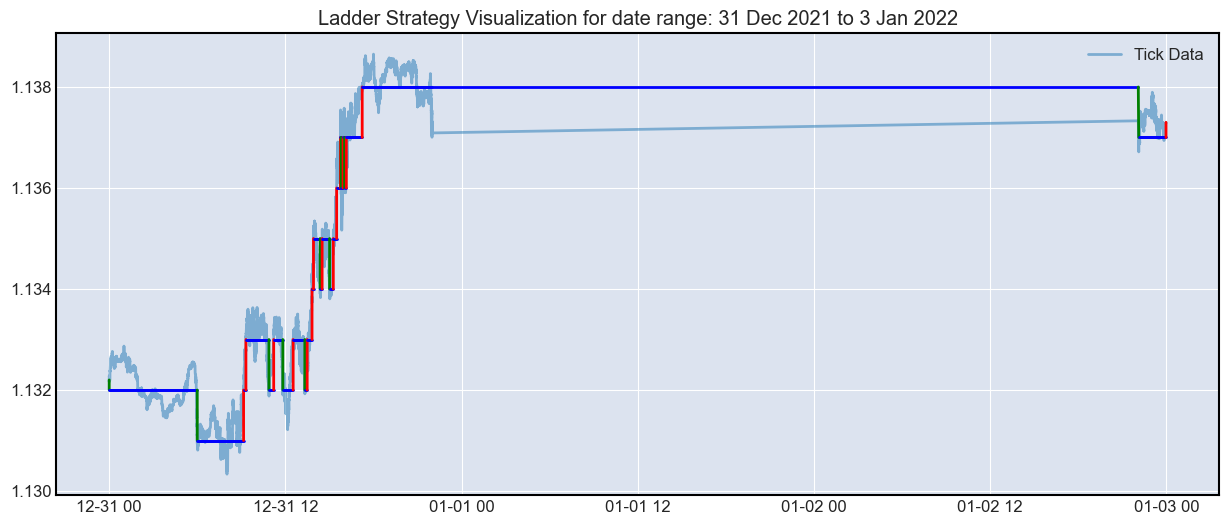

In [97]:
plot_ladderized('31 Dec 2021','3 Jan 2022',grid_size=0.001,ladderize_function=ladderize_absolute_optimised)

### filter jumps and plot 

In [90]:
def filter_jumps(ladderized_data):
    """
    Filters ladderized data to keep only the changes in price.

    :param ladderized_data: A pandas Series of ladderized data.
    :return: A pandas Series containing only the data points where there's a change.
    """
    # Calculate the difference between consecutive ladderized data points
    diff = ladderized_data.diff()
    # Filter where the difference is non-zero and include the first data point
    jumps = ladderized_data[diff != 0.0]
    return jumps


In [91]:
def aggregate_differences(jumps,lot_size=1):
    """
    Aggregate the position for buy/sell signals.

    :param jumps: A pandas Series of ladderized data filtered for jumps.
    :return: A pandas Series representing the aggregated position.
    """
    aggregated_position = [0]  # starting from 0
    position = 0
    previous_value = jumps.values[0]
    
    for value in jumps.values[1:]:
        if value > previous_value:
            position -= lot_size  # selling one lot
        else:
            position += lot_size  # buying one lot
        aggregated_position.append(position)
        previous_value = value
    aggregated_position[-1]=0 # closing the position
    return pd.Series(aggregated_position, index=jumps.index)


In [92]:
def plot_jumps(ladderized_data):
    jumps = filter_jumps(ladderized_data)
    aggregated_diff = aggregate_differences(jumps)
    fig,axs = plt.subplots(2,1,figsize=(10,10))
    # Plotting the jumps
    axs[0].plot(jumps.values, label='binomial jumps', linestyle='--', alpha=0.7)
    axs[0].set_title('ladder with jumps')
    # Adding colored points for up and down movements
    previous_value = jumps.values[0]
    for idx, value in enumerate(jumps.values[1:], 1):
        if idx == len(jumps)-1:
            continue
        elif value > previous_value:
            axs[0].plot(idx, value, 'ro')  # Red point for upward movement
        elif value < previous_value:
            axs[0].plot(idx, value, 'go')  # green point for downward movement
        else:
            axs[0].plot(idx, value, 'bo') # blue point for no change
        previous_value = value
        
        # Add vertical line to all subplots
        for ax in axs:
            ax.axvline(idx, alpha=0.5, color='gray')
            
            
    axs[0].legend()
    # Plotting the aggregated differences
    axs[1].plot(aggregated_diff.values, label='position', linestyle='-', color='purple', alpha=0.8, drawstyle='steps-post')
    axs[1].legend()
    axs[1].set_title('positions')
    plt.show()

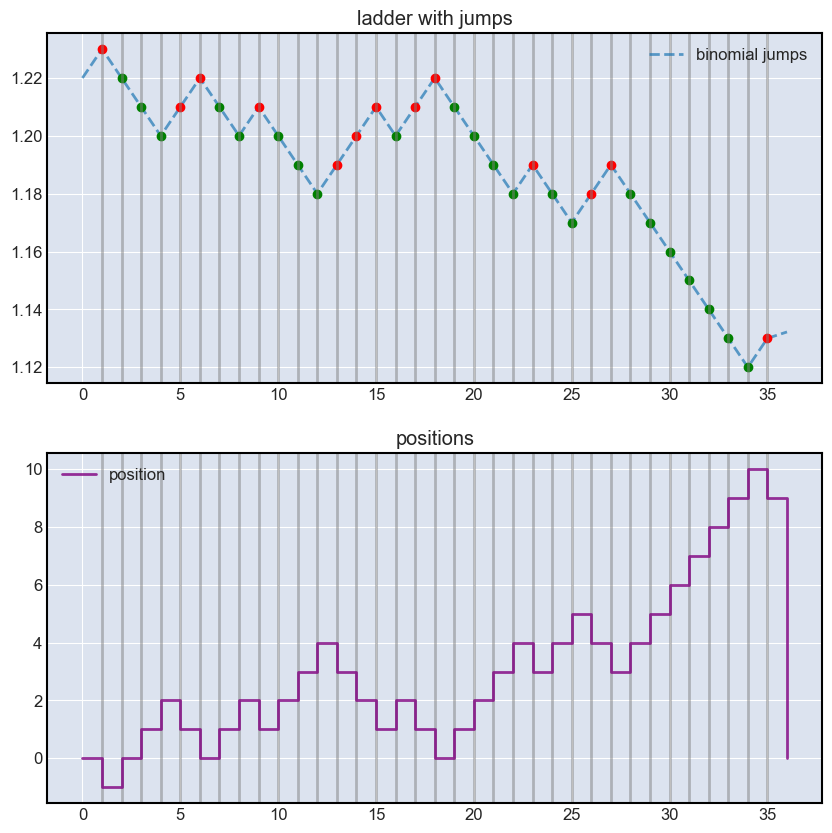

In [93]:
plot_jumps(ladderized_data)

KeyboardInterrupt: 

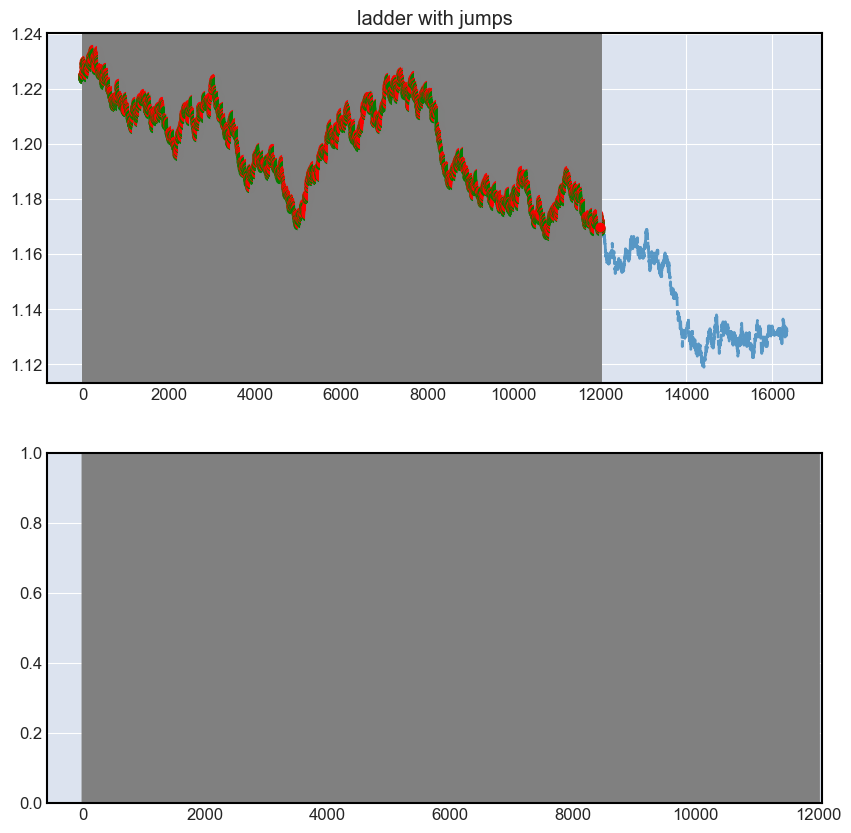

In [94]:
for grid_sizing in [0.0005, 0.001, 0.002, 0.005]:
    ladderised_data = ladderize_absolute_optimised(tick_data, grid_size=grid_sizing)
    plot_jumps(ladderised_data)

### indicators for lot sizing

In [38]:
def velocity(data,grid_sizing,indicator_scale=5):
    return np.round(indicator_scale*data.diff()/(data)/grid_sizing,1)

def acceleration(data,grid_sizing,indicator_scale=5):
    return np.round(indicator_scale*data.diff().diff()/(data)/grid_sizing,1)

In [39]:
jumps = filter_jumps(ladderized_data)
jump_ema = jumps.ewm(span=10).mean()

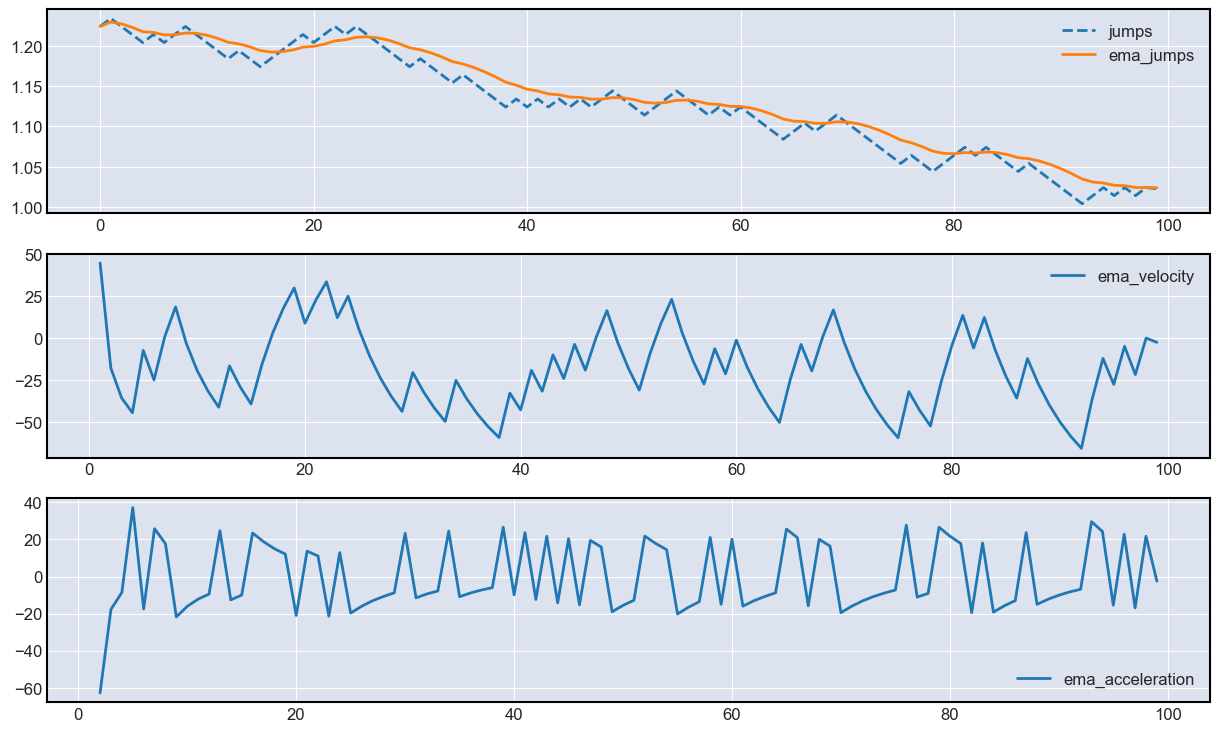

In [40]:
# Plot the results
fig,axs = plt.subplots(3,1,figsize=(15,9))
axs[0].plot(jumps.values, label='jumps', linestyle='--')
axs[0].plot(jump_ema.values, label='ema_jumps', linestyle='-')
#axs[0].plot(ladderized_data, label='Ladderized Data',alpha=0.5)
axs[0].legend()
axs[1].plot(velocity(jump_ema,grid_sizing).values, label='ema_velocity')
axs[1].legend()
axs[2].plot(acceleration(jump_ema,grid_sizing).values, label='ema_acceleration')
axs[2].legend()
plt.show() 

### applying depth sizing and conversion to binomial

In [41]:
def apply_depth_constraint(data, depth):
    sum = 0
    for i,point in enumerate(data):
        sum = sum + point
        if (sum > depth) and (point > 0):
            data[i] = 0
            sum = sum - point
        elif (sum < -depth) and (point < 0):
            data[i] = 0
            sum = sum - point
        else:
            continue
    return data

In [42]:
def convert_to_grid_binomial_data(tick_data,grid_size,ladderized_function,ladder_depth=10):
    """
    Convert tick data to a binomial grid representation using a ladderized function.

    Parameters:
    - tick_data (pd.Series or np.array): The raw tick data to be processed.
    - grid_size (float): The size of the grid to which the tick data will be mapped.
    - ladderized_function (callable): A function that ladderizes the tick data based on the grid size.
    - ladder_depth (int, optional): The maximum depth of the ladder. Default is 10.

    Returns:
    - tuple:
        - jumps (pd.Series or np.array): The ladderized tick data after filtering jumps.
        - binomial_data (pd.Series or np.array): The binomial representation of the tick data, where 1 indicates an upward move, -1 indicates a downward move, and 0 indicates no move beyond the ladder depth.

    Notes:
    The function first ladderizes the tick data using the provided ladderized function. It then identifies and filters out jumps in the ladderized data. The differences between consecutive ladderized data points are computed to generate the binomial representation. The binomial data is then adjusted such that any cumulative sum (or ladder aggregate) beyond the specified ladder depth is set to 0.

    Example:
    Given tick_data as [100, 101, 102, 104], grid_size as 1, and ladderized_function that rounds to the nearest integer:
    The ladderized data might be [100, 101, 102, 104]
    The jumps, after filtering, might remain the same.
    The binomial data would be [0, 1, 1, 1]
    """
    ladderized_data = ladderized_function(tick_data,grid_size)
    jumps = filter_jumps(ladderized_data)
    binomial_data = jumps.diff()
    binomial_data[1:] = np.where(binomial_data[1:] > 0,1,-1) # 1 for up and -1 for down
    binomial_data[0] = 0 # first value is always 0
    binomial_data = apply_depth_constraint(binomial_data,ladder_depth)
    return jumps,binomial_data

In [43]:
def timed_convert_to_grid_binomial_data(tick_data,grid_size,ladderized_function,ladder_depth=10):
    """
    Convert tick data to a binomial grid representation using a ladderized function.

    Parameters:
    - tick_data (pd.Series or np.array): The raw tick data to be processed.
    - grid_size (float): The size of the grid to which the tick data will be mapped.
    - ladderized_function (callable): A function that ladderizes the tick data based on the grid size.
    - ladder_depth (int, optional): The maximum depth of the ladder. Default is 10.

    Returns:
    - tuple:
        - jumps (pd.Series or np.array): The ladderized tick data after filtering jumps.
        - binomial_data (pd.Series or np.array): The binomial representation of the tick data, where 1 indicates an upward move, -1 indicates a downward move, and 0 indicates no move beyond the ladder depth.

    Notes:
    The function first ladderizes the tick data using the provided ladderized function. It then identifies and filters out jumps in the ladderized data. The differences between consecutive ladderized data points are computed to generate the binomial representation. The binomial data is then adjusted such that any cumulative sum (or ladder aggregate) beyond the specified ladder depth is set to 0.

    Example:
    Given tick_data as [100, 101, 102, 104], grid_size as 1, and ladderized_function that rounds to the nearest integer:
    The ladderized data might be [100, 101, 102, 104]
    The jumps, after filtering, might remain the same.
    The binomial data would be [0, 1, 1, 1]
    """
    time1 = time.time()
    ladderized_data = ladderized_function(tick_data,grid_size)
    time2 = time.time()
    jumps = filter_jumps(ladderized_data)
    time3 = time.time()
    binomial_data = jumps.diff()
    binomial_data[1:] = np.where(binomial_data[1:] > 0,1,-1) # 1 for up and -1 for down
    binomial_data[0] = 0 # first value is always 0
    time4 = time.time()
    binomial_data = apply_depth_constraint(binomial_data,ladder_depth)
    time5 = time.time()
    print('ladderize time: ',time2-time1)
    print('filter jumps time: ',time3-time2)
    print('binomial data time: ',time4-time3)
    print('apply depth constraint time: ',time5-time4)
    return jumps,binomial_data

In [103]:
grid_jumps,binomial_data = timed_convert_to_grid_binomial_data(tick_data,0.001,ladderize_open)

ladderize time:  234.6843180656433
filter jumps time:  0.06511902809143066
binomial data time:  0.0011680126190185547
apply depth constraint time:  0.007672786712646484


In [50]:
np.max(np.cumsum(binomial_data))

10.0

## Strategy

### load the data

In [51]:
start_date = '1 Jan 2021'
end_date = '31 Jul 2021'
tick_data = data_gather_from_files(start_date,end_date)['EURUSD.mid']

In [52]:
grid_sizing = 0.002
lot_sizing = 1000000
grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladderize_absolute_optimised,ladder_depth=10)

In [53]:
np.max(np.cumsum(binomial_data))

10.0

### function that helps scale and build lot sizing based on indicators and trade_depth

In [54]:
def build_lot_sizing(lot_sizing,binomial_data,multiplier=1,indicator_data=[],min_lot_size = 1000):
    """
    Compute the lot sizing for trading based on binomial data and optional indicator data.

    Parameters:
    - lot_sizing (float): Base lot size for trading.
    - binomial_data (pd.Series or np.array): Binomial representation of tick data, where 1 indicates an upward move, -1 indicates a downward move.
    - multiplier (float, optional): Multiplier for scaling the lot size. Default is 1.
    - indicator_data (list or np.array, optional): Additional data used for scaling the lot size based on the direction of the binomial data. Default is an empty list.

    Returns:
    - np.array: Array of lot sizes for each time step.

    Notes:
    If no indicator data is provided, the function returns a list of lot sizes scaled by the multiplier for each time step.
    If indicator data is provided, the function scales the lot size based on the alignment of the binomial data and the indicator data. Specifically, if both the binomial data and the indicator data have the same sign (indicating movement in the same direction), the lot size is inversely scaled. Otherwise, it is scaled up.

    Example:
    Given lot_sizing as 10, binomial_data as [1, -1, 1], multiplier as 2, and indicator_data as [1, -1, 1]:
    The resulting lot sizes would be [10, 20, 5] (assuming rounding for simplicity).
    """
    T = len(binomial_data)
    if len(indicator_data) == 0: # No indicator data
        return [lot_sizing * (multiplier**i) for i in range(T)]
    else: # Indicator data is present
        scaling_criteria =  binomial_data * indicator_data  # +ve if both are same sign hence signifies movement in same direction, we scale in by inverse
        #positions = np.where(scaling_criteria > 0,1/(1+abs(scaling_criteria)),1+abs(scaling_criteria))*lot_sizing # +ve if both are same sign hence signifies movement in same direction , we do not scale in that case
        positions = np.where(scaling_criteria > 0,1,1+abs(scaling_criteria))*lot_sizing
        positions[np.isnan(positions)] = 0
        return np.round(positions/min_lot_size,0)*min_lot_size

### Prepares the indicator data for the scaling the lot sizing

In [55]:
def indicator_prep(data,grid_sizing,lookback = 200,Type = 'v',indicator_scale=5):
    if Type == 'a':
        data = acceleration(data.ewm(span=lookback).mean(),grid_sizing,indicator_scale).shift(1)
    elif Type == 'v':
        data = velocity(data.ewm(span=lookback).mean(),grid_sizing,indicator_scale).shift(1) # we shift this because our lot sizing will be decided by what the values are prior not current
    else:
        print('wrong Indicator type')
        return None
    data[np.isnan(data)] = 0
    return data

In [56]:
indicator_data = indicator_prep(grid_jumps,grid_sizing)

In [57]:
indicator_data

Date
2021-01-03 22:00:00.040000+00:00    0.0
2021-01-04 07:08:31.705000+00:00    0.0
2021-01-04 08:32:37.464000+00:00    2.1
2021-01-04 09:37:52.229000+00:00    2.1
2021-01-04 15:08:15.464000+00:00    2.1
                                   ... 
2021-07-29 10:22:04.666000+00:00   -0.1
2021-07-30 08:34:08.011000+00:00   -0.1
2021-07-30 12:50:25.994000+00:00   -0.0
2021-07-30 14:48:15.559000+00:00   -0.1
2021-07-30 20:59:56.206000+00:00   -0.1
Length: 649, dtype: float64

In [58]:
position_data = build_lot_sizing(lot_sizing,binomial_data,multiplier=1,indicator_data=indicator_data)

In [59]:
position_data

array([1000000., 1000000., 1000000., 1000000., 3100000., 1400000.,
       1400000., 1300000., 1300000., 1000000., 1000000., 1900000.,
       1400000., 1000000., 1000000., 1000000., 1800000., 1400000.,
       1000000., 1300000., 1100000., 1100000., 1000000., 1000000.,
       1400000., 1200000., 1000000., 1000000., 1300000., 1000000.,
       1000000., 1400000., 1000000., 1000000., 1500000., 1300000.,
       1200000., 1000000., 1200000., 1000000., 1000000., 1300000.,
       1000000., 1200000., 1000000., 1000000., 1000000., 1400000.,
       1000000., 1000000., 1000000., 1000000., 1600000., 1000000.,
       1600000., 1000000., 1500000., 1400000., 1300000., 1200000.,
       1000000., 1000000., 1000000., 1400000., 1000000., 1000000.,
       1400000., 1000000., 1400000., 1000000., 1000000., 1400000.,
       1400000., 1000000., 1000000., 1400000., 1000000., 1000000.,
       1000000., 1000000., 1600000., 1500000., 1400000., 1300000.,
       1000000., 1300000., 1000000., 1000000., 1000000., 14000

### function to plot trades , positions (in dollar terms) and PNL (realised , unrealised and total)

In [60]:
def plot_trades(grid_jumps, R_PNL, U_PNL, N, lookback=200):
    """
    Plot trading data including buy/sell points, lot sizes held, and PNL.

    Parameters:
    - grid_jumps (pd.Series): Ladderized tick data after filtering jumps.
    - R_PNL (pd.Series or np.array): Realized Profit and Loss (PNL) over time.
    - U_PNL (pd.Series or np.array): Unrealized Profit and Loss (PNL) over time.
    - N (pd.Series or np.array): Number of lots held over time.
    - lookback (int, optional): Lookback period for the exponential moving average (EMA) indicator. Default is 200.

    Returns:
    - None: Displays a matplotlib plot with three subplots.

    Notes:
    The function generates a plot with three subplots:
    1. Buy/sell points: This subplot displays the grid jumps with an EMA overlay. Buy points are indicated with red dots, sell points with green dots, and no change with blue dots.
    2. Lots held: This subplot displays the number of lots held over time.
    3. PNL: This subplot displays the unrealized PNL, realized PNL, and total PNL over time.

    Each buy/sell/no-change point in the first subplot corresponds to a vertical line across all subplots for visual alignment.

    Example:
    Given grid_jumps as a time series of ladderized tick data, R_PNL and U_PNL as time series of realized and unrealized PNL respectively, and N as a time series of lots held, the function will display the described plots.
    """
    fig,axs = plt.subplots(3,1,figsize=(15,15))
    axs[0].plot(grid_jumps.values, label='jumps', linestyle='--')
    axs[0].plot(grid_jumps.ewm(span=lookback).mean().values, label='indicator', linestyle='-',alpha=0.6)
    for idx, i in enumerate(grid_jumps):
        if grid_jumps[idx] > grid_jumps[idx-1]:
            axs[0].plot(idx, i, 'ro')  # Red point for upward movement
        elif grid_jumps[idx] < grid_jumps[idx-1]:
            axs[0].plot(idx, i, 'go')  # Green point for downward movement
        else:
            axs[0].plot(idx, i, 'bo')  # Blue point for no change

        # Add vertical line to all subplots
        for ax in axs:
            ax.axvline(idx, alpha=0.2, color='gray')

    axs[0].set_title('buy sell points')
    axs[1].plot(N,drawstyle='steps-post')
    # change number of digits in y axis
    axs[1].yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    axs[1].set_title('lots held')
    axs[2].plot(U_PNL,drawstyle='steps-post',label='Unrealised PNL')
    axs[2].plot(R_PNL,drawstyle='steps-post',label='Realised PNL')
    axs[2].plot(U_PNL+R_PNL,drawstyle='steps-post',label='Total PNL')
    axs[2].legend()
    axs[2].set_title('PNL')
    plt.show()


### Function to format the data in our dataframe 

In [61]:
def format_df(df):
    # Set the display option for floats
    pd.options.display.float_format = '{:,.2f}'.format

    # Format the DataFrame
    formatted_df = df.style.format({
        't': '{:,.0f}',  # Fixed the missing quotation mark here
        'price': '{:,.3f}',
        'Previous_lots': '{:,.0f}',
        'current_lots': '{:,.0f}',  # Fixed the missing quotation mark here
        'position': '{:,.2f}',
        'Unrealised_PNL': '{:,.2f}',
        'Realized_PNL': '{:,.2f}'
    })
    
    return formatted_df

### initial strategy function - gives only cummulative profits.

In [105]:
def run_strategy_total_PNL(tick_data,grid_sizing,lot_sizing,ladder_depth=10,ladder_function=ladderize_absolute_optimised,multiplier=1,indicator = False,lookback = 200,print_trade_book=False,trade_plot=False):
    """
    Run a continuous trading strategy based on ladderized tick data.

    Parameters:
    - tick_data: Series, raw tick data
    - grid_sizing: float, grid size for ladderization
    - lot_sizing: float, initial lot size for trading
    - ladder_function: function, ladderization function (default is ladderize_absolute)
    - multiplier: float, multiplier for position sizing (default is 1)
    - indicator: bool, whether to use an indicator for position sizing (default is False)
    - print_trade_book: bool, whether to print the trade book (default is False)
    - trade_plot: bool, whether to plot the trades (default is False)

    Returns:
    - PNL: array, profit and loss for each time step
    - N: array, number of lots held at each time step
    - P: array, position value at each time step
    - trades: DataFrame, trade book
    """
    grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladder_function,ladder_depth)
    indicator_data = []
    if indicator:
        indicator_data = indicator_prep(grid_jumps,grid_sizing,lookback=lookback)
        

    T = len(binomial_data)
    PNL = np.zeros(T)
    P = np.zeros(T)
    N = np.zeros(T)
    trades = pd.DataFrame(columns=['t','price','Previous_lots','current_lots','position','PNL'])
    
    position_sizing = build_lot_sizing(lot_sizing,binomial_data,multiplier=multiplier,indicator_data=indicator_data)
    
    for t in np.arange(0,T):
        N[t] = N[t-1] - position_sizing[t] * binomial_data[t]
        P[t] = N[t] * grid_jumps[t]
        PNL[t] = PNL[t-1] + N[t-1] * (grid_jumps[t] - grid_jumps[t-1])
        PNL[t]=np.round(PNL[t],2)
        if print_trade_book:
            print('t = {}, price={}, Previous_lots = {},  current_lots= {}, position = {}, PNL = {}'.format(t,grid_jumps[t],N[t-1],N[t],P[t],PNL[t]))
        trade = pd.Series({'t':t,'price':grid_jumps[t],'Previous_lots':N[t-1],'current_lots':N[t],'position':P[t],'PNL':PNL[t]})
        trades = pd.concat([trades, trade.to_frame().T])
    if trade_plot:
        plot_trades(grid_jumps,PNL,N,lookback=lookback)
    trades = format_df(trades)
    return PNL,N,P,trades


In [63]:
# PNL, P ,N, trades = run_strategy_total_PNL(tick_data,grid_sizing,lot_sizing)

### Actual strategy function - calculates all the metrics but is inefficient

In [120]:
def run_strategy_eval(tick_data,grid_sizing,lot_sizing,ladder_depth=10,ladder_function=ladderize_absolute_optimised,multiplier=1,indicator = False,lookback = 200,print_trade_book=False,trade_plot=False):
    """
    Evaluate and visualize a trading strategy based on ladderized tick data and optional indicators.

    Parameters:
    - tick_data (pd.Series or np.array): The raw tick data to be processed.
    - grid_sizing (float): The size of the grid to which the tick data will be mapped.
    - lot_sizing (float): Base lot size for trading.
    - ladder_function (callable, optional): A function that ladderizes the tick data based on the grid size. Default is ladderize_absolute.
    - multiplier (float, optional): Multiplier for scaling the lot size. Default is 1.
    - indicator (bool, optional): Flag to determine if an indicator should be used. Default is False.
    - lookback (int, optional): Lookback period for the indicator. Default is 200.
    - print_trade_book (bool, optional): Flag to print trade details for each time step. Default is False.
    - trade_plot (bool, optional): Flag to plot the trading data. Default is False.

    Returns:
    - pd.DataFrame: A dataframe containing trade details for each time step, including price, lots, position, realized and unrealized PNL, and average price.

    Notes:
    The function evaluates a trading strategy based on ladderized tick data and optional indicators. It computes the realized and unrealized PNL, position, and average price for each time step. The function can also print trade details for each time step and plot the trading data.

    The strategy is evaluated by first converting the tick data to a binomial grid representation using the provided ladder function. If an indicator is used, it is prepared based on the grid jumps and grid sizing. The position sizing is then computed based on the binomial data, lot sizing, multiplier, and optional indicator data.

    The function then iterates over each time step, computing the number of lots in order, position, realized and unrealized PNL, and average price. The results are stored in a dataframe, which is returned.

    """
    grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladder_function,ladder_depth)
    indicator_data = []
    if indicator:
        indicator_data = indicator_prep(grid_jumps,grid_sizing,lookback=lookback)
        

    T = len(binomial_data)
    PNL = np.zeros(T)
    R_PNL = np.zeros(T)
    U_PNL = np.zeros(T)
    P = np.zeros(T)
    N = np.zeros(T)
    trades = pd.DataFrame(columns=['t','price','Previous_lots','current_lots','position','R_PNL','U_PNL','PNL'])
    
    position_sizing = build_lot_sizing(lot_sizing,binomial_data,multiplier=multiplier,indicator_data=indicator_data)
    avg_price = 0
    for t in np.arange(0,T):
        lots_in_order = - position_sizing[t] * binomial_data[t]
        N[t] = N[t-1] + lots_in_order
        P[t] = N[t] * grid_jumps[t] 

        if (N[t]*lots_in_order <= 0) and (lots_in_order != 0):# if we are closing a position 
        # we check if the final position and the order are in opposite directions and if the order is not 0 (i.e. we are not opening a position)
        # ----- need to improve condition when we have lot size scaling. (lets say we are - ve 10 and we buy 20 we have realised PNL only for the first 10)
            R_PNL[t] = R_PNL[t-1] - (grid_jumps[t] - avg_price) * lots_in_order # realised PNL
        else: # if we are opening a position or adding to an existing position
            R_PNL[t] = R_PNL[t-1] # realised PNL remains the same
            if N[t]!=0: # since we are adding to an existing position we need to update the avg price
                avg_price = (avg_price * N[t-1] + grid_jumps[t]*lots_in_order)/N[t] # update avg price
            # if N[t] == 0 we are closing a position and hence avg price is not updated

        PNL[t] = PNL[t-1] + N[t-1] * (grid_jumps[t] - grid_jumps[t-1])
        
        U_PNL[t] = (grid_jumps[t] - avg_price) * N[t] # unrealised PNL
        
        PNL[t]=np.round(PNL[t],4)
        U_PNL[t]=np.round(U_PNL[t],4)
        R_PNL[t]=np.round(R_PNL[t],4)
        
        
        # checks if profit calculations are right
        test = True  # set to true to test
        error = np.round(PNL[t] - R_PNL[t] - U_PNL[t],2) # total profit must be equal to cumulative sum of realised + unrealised profit
        if (error!=0) and test:
            print('error at t = {}, error = {}'.format(t,error))

        
        if print_trade_book:
            print('At t = {}'.format(t))
            if t == 0:
                print('no trades')
            elif lots_in_order > 0:
                print('buy {} lots at price {}'.format(lots_in_order,grid_jumps[t]))
            else:
                print('sell {} lots at price {}'.format(-lots_in_order,grid_jumps[t]))
            print('average price = {}'.format(avg_price))
            print('cummulative realised PNL = {}'.format(R_PNL[t]))
            print('unrealised PNL = {}'.format(U_PNL[t]))
            print('PNL = {}'.format(PNL[t]))
        trade = pd.Series({'t':t,'price':grid_jumps[t],'Previous_lots':N[t-1],'current_lots':N[t],'position':P[t],'R_PNL':R_PNL[t],'U_PNL':U_PNL[t],'PNL':PNL[t],'average_price':avg_price})
        trades = pd.concat([trades, trade.to_frame().T])
    if trade_plot:
        plot_trades(grid_jumps,R_PNL,U_PNL,N,lookback=lookback)
        print(format_df(trades))
    return PNL,R_PNL,U_PNL,N,P

### trade without indicator

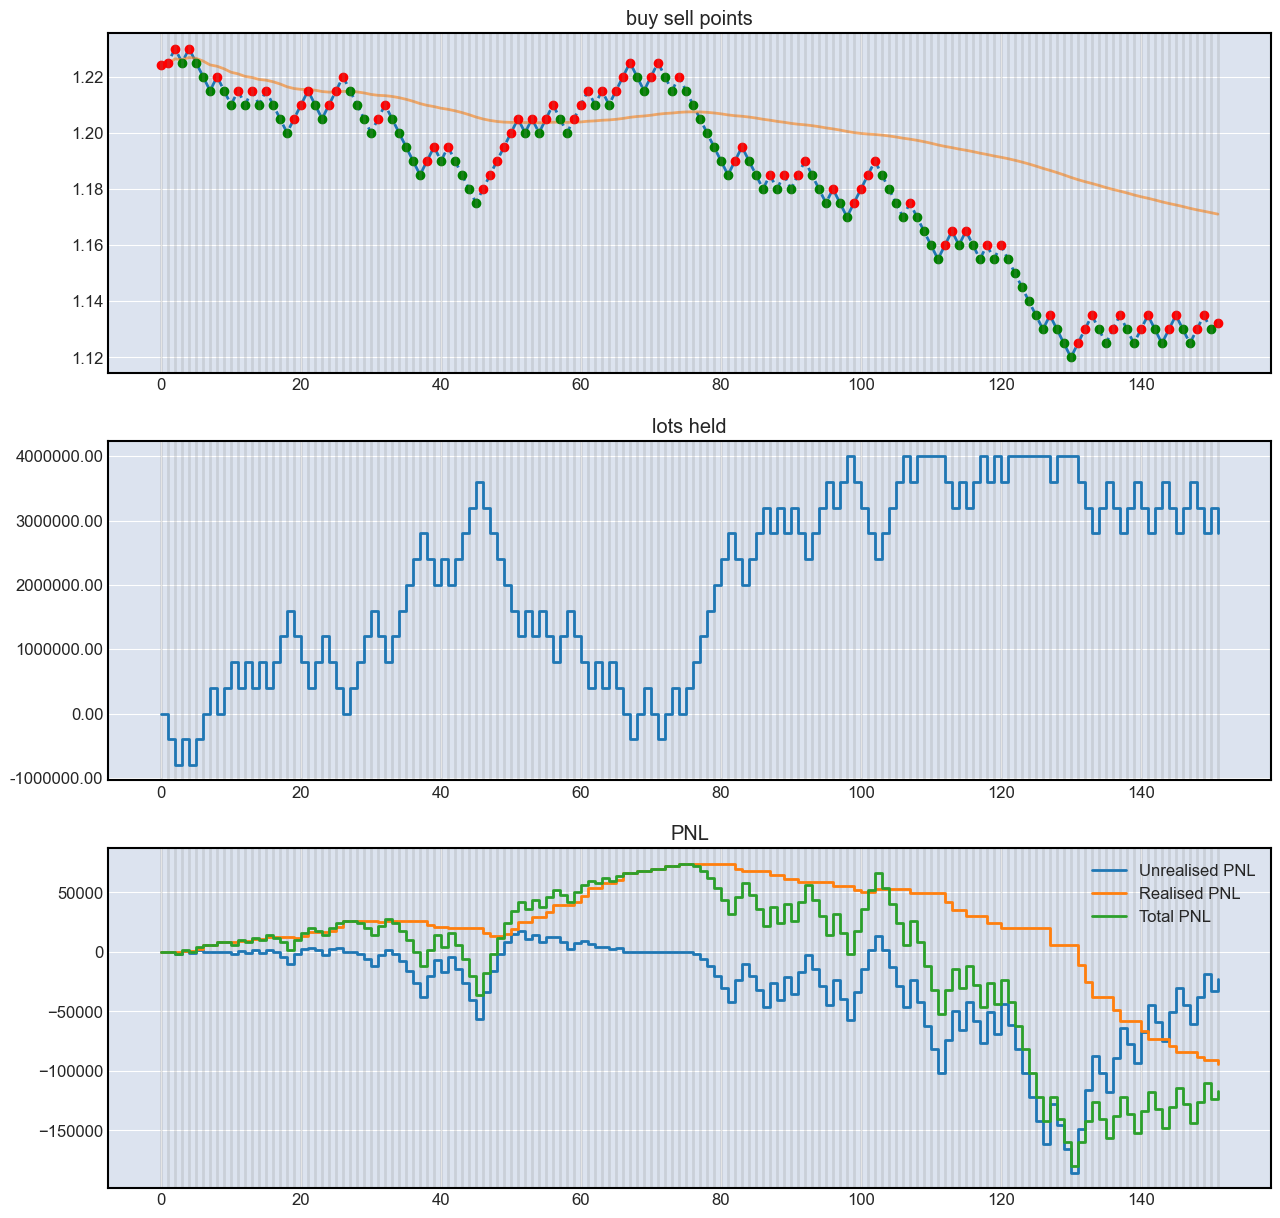

(array([      0.,       0.,   -2000.,    2000.,       0.,    4000.,
           6000.,    6000.,    8000.,    8000.,    6000.,   10000.,
           8000.,   12000.,   10000.,   14000.,   12000.,    8000.,
           2000.,   10000.,   16000.,   20000.,   18000.,   14000.,
          20000.,   24000.,   26000.,   26000.,   24000.,   20000.,
          14000.,   22000.,   28000.,   24000.,   18000.,   10000.,
             -0.,  -12000.,    2000.,   14000.,    4000.,   16000.,
           6000.,   -6000.,  -20000.,  -36000.,  -18000.,   -2000.,
          12000.,   24000.,   34000.,   42000.,   36000.,   44000.,
          38000.,   46000.,   52000.,   48000.,   42000.,   50000.,
          56000.,   60000.,   58000.,   62000.,   60000.,   64000.,
          66000.,   66000.,   68000.,   68000.,   70000.,   70000.,
          72000.,   72000.,   74000.,   74000.,   72000.,   68000.,
          62000.,   54000.,   44000.,   32000.,   46000.,   58000.,
          48000.,   36000.,   22000.,   38000., 

In [121]:
run_strategy_eval(tick_data,grid_sizing=0.005,lot_sizing=400000,trade_plot=True)

### trade with indicator

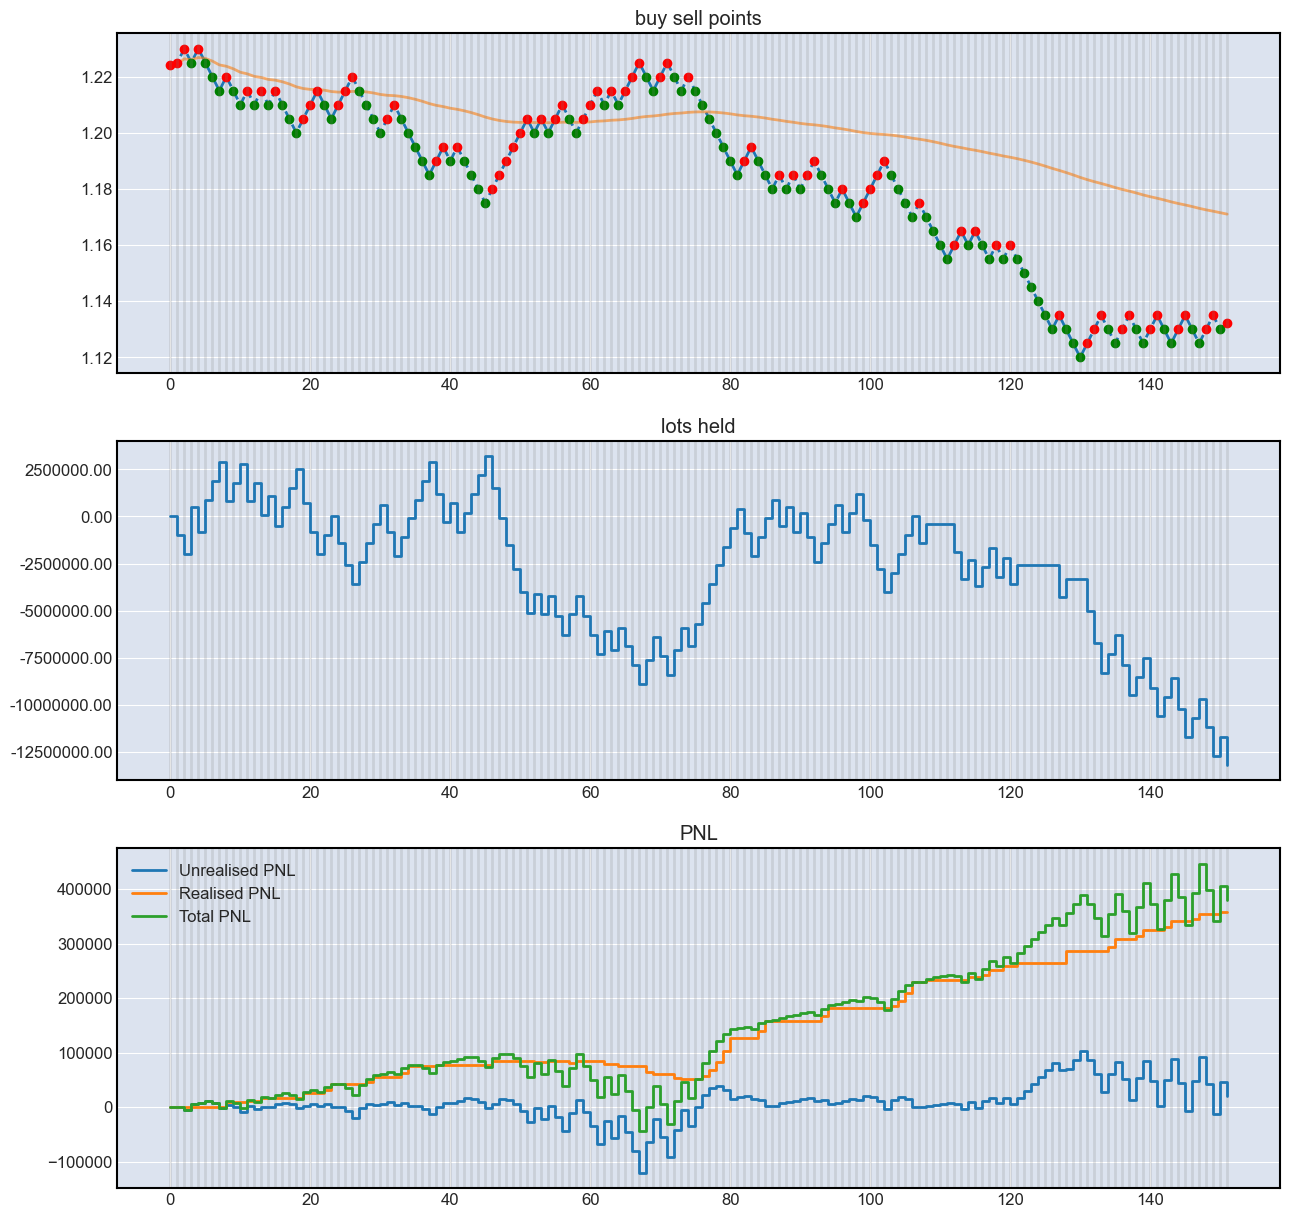

(array([     0.,      0.,  -5000.,   5000.,   7500.,  11500.,   7000.,
         -2500.,  12000.,   8000.,  -1000.,  13000.,   9000.,  18000.,
         17500.,  23000.,  25500.,  23000.,  15500.,  28000.,  31500.,
         27500.,  37500.,  42500.,  42500.,  35500.,  22500.,  40500.,
         52500.,  59500.,  61500.,  64500.,  60500.,  71000.,  76500.,
         77000.,  72500.,  63000.,  77500.,  83500.,  85000.,  88500.,
         92500.,  91500.,  85500.,  74500.,  90500.,  98000.,  97500.,
         90000.,  76000.,  56000.,  81500.,  61000.,  87000.,  66000.,
         39500.,  71000.,  97000.,  76000.,  49500.,  18000.,  54500.,
         24000.,  59500.,  30000.,  -4500., -44000.,    500.,  38500.,
          6500., -30500.,  11500.,  47000.,  17500.,  52000.,  80500.,
        103500., 121500., 134500., 142500., 145500., 147500., 143000.,
        153500., 159000., 159500., 164000., 166500., 169000., 173000.,
        174000., 168500., 180500., 187500., 189500., 192500., 196500.,
      

In [124]:
run_strategy_eval(tick_data,grid_sizing=0.005,lot_sizing=1000000,indicator=True,lookback=200,trade_plot=True)

### built optimised code to run in optimisation equations.

In [128]:
def run_strategy_optimised(tick_data,grid_sizing,lot_sizing,ladder_depth = 10,ladder_function=ladderize_absolute_optimised,multiplier=1,indicator = False,lookback = 200):

    grid_jumps,binomial_data = convert_to_grid_binomial_data(tick_data,grid_sizing,ladder_function,ladder_depth)
    indicator_data = []
    if indicator:
        indicator_data = indicator_prep(grid_jumps,grid_sizing,lookback=lookback)

    T = len(binomial_data)
    
    current_lots = 0
    previous_lots = 0
    R_PNL = 0
    U_PNL = 0
    PNL = 0
    position = 0
    position_sizing = build_lot_sizing(lot_sizing,binomial_data,multiplier=multiplier,indicator_data=indicator_data)
    avg_price = 0
    max_position = 0
    min_U_PNL = 0
    max_loss = 0
    for t in np.arange(0,T):
        lots_in_order = - position_sizing[t] * binomial_data[t]
        previous_lots = current_lots
        current_lots = previous_lots + lots_in_order
        position = current_lots * grid_jumps[t] 

        if (current_lots*lots_in_order <= 0) and (lots_in_order != 0):# if we are closing a position 
        # we check if the final position and the order are in opposite directions and if the order is not 0 (i.e. we are not opening a position)
        # ----- need to improve condition when we have lot size scaling. (lets say we are - ve 10 and we buy 20 we have realised PNL only for the first 10)
            R_PNL -= (grid_jumps[t] - avg_price) * lots_in_order # realised PNL
        else: # if we are opening a position or adding to an existing position
            if current_lots!=0: # since we are adding to an existing position we need to update the avg price
                avg_price = (avg_price * previous_lots + grid_jumps[t]*lots_in_order)/current_lots # update avg price
            # if N[t] == 0 we are closing a position and hence avg price is not updated

        PNL = PNL + previous_lots * (grid_jumps[t] - grid_jumps[t-1])
        
        U_PNL = (grid_jumps[t] - avg_price) * current_lots # unrealised PNL

        PNL=np.round(PNL,4)
        U_PNL=np.round(U_PNL,4)
        R_PNL=np.round(R_PNL,4)
        if U_PNL < min_U_PNL:
            min_U_PNL = U_PNL
        if abs(position) > max_position:
            max_position = abs(position)
        if PNL < max_loss:
            max_loss = PNL
    return max_loss, min_U_PNL, max_position, R_PNL

In [129]:
tick_data = data_gather_from_files('1 Jan 2021','31 dec 2021')['EURUSD.mid']

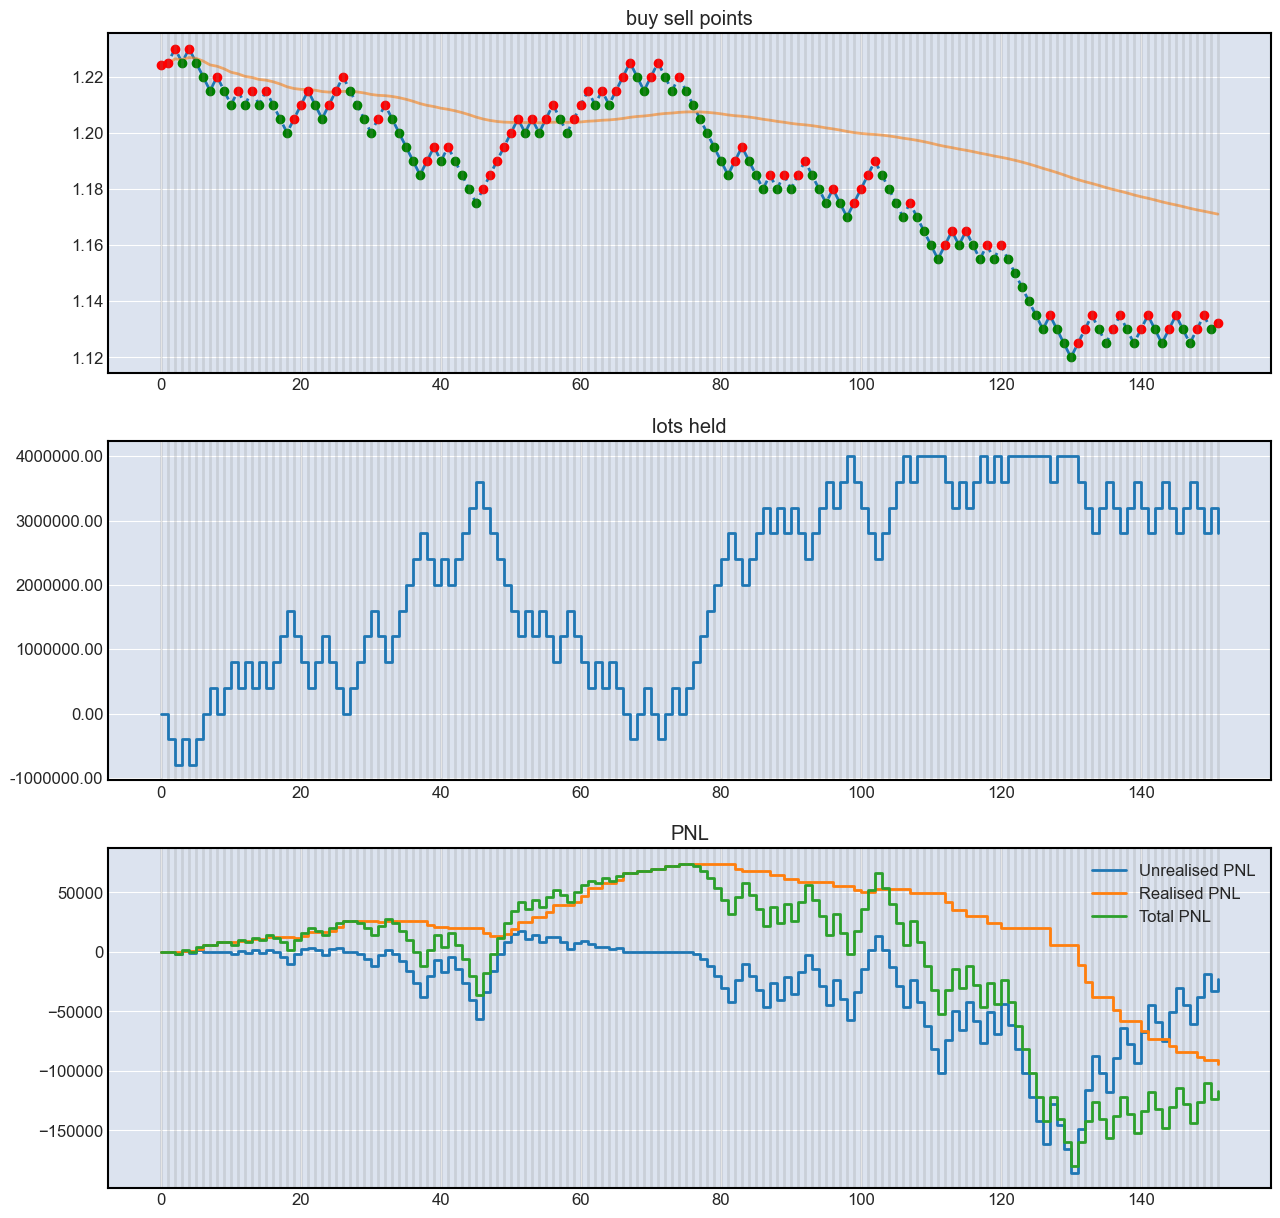

(array([      0.,       0.,   -2000.,    2000.,       0.,    4000.,
          6000.,    6000.,    8000.,    8000.,    6000.,   10000.,
          8000.,   12000.,   10000.,   14000.,   12000.,    8000.,
          2000.,   10000.,   16000.,   20000.,   18000.,   14000.,
         20000.,   24000.,   26000.,   26000.,   24000.,   20000.,
         14000.,   22000.,   28000.,   24000.,   18000.,   10000.,
            -0.,  -12000.,    2000.,   14000.,    4000.,   16000.,
          6000.,   -6000.,  -20000.,  -36000.,  -18000.,   -2000.,
         12000.,   24000.,   34000.,   42000.,   36000.,   44000.,
         38000.,   46000.,   52000.,   48000.,   42000.,   50000.,
         56000.,   60000.,   58000.,   62000.,   60000.,   64000.,
         66000.,   66000.,   68000.,   68000.,   70000.,   70000.,
         72000.,   72000.,   74000.,   74000.,   72000.,   68000.,
         62000.,   54000.,   44000.,   32000.,   46000.,   58000.,
         48000.,   36000.,   22000.,   38000.,   24000.,   40

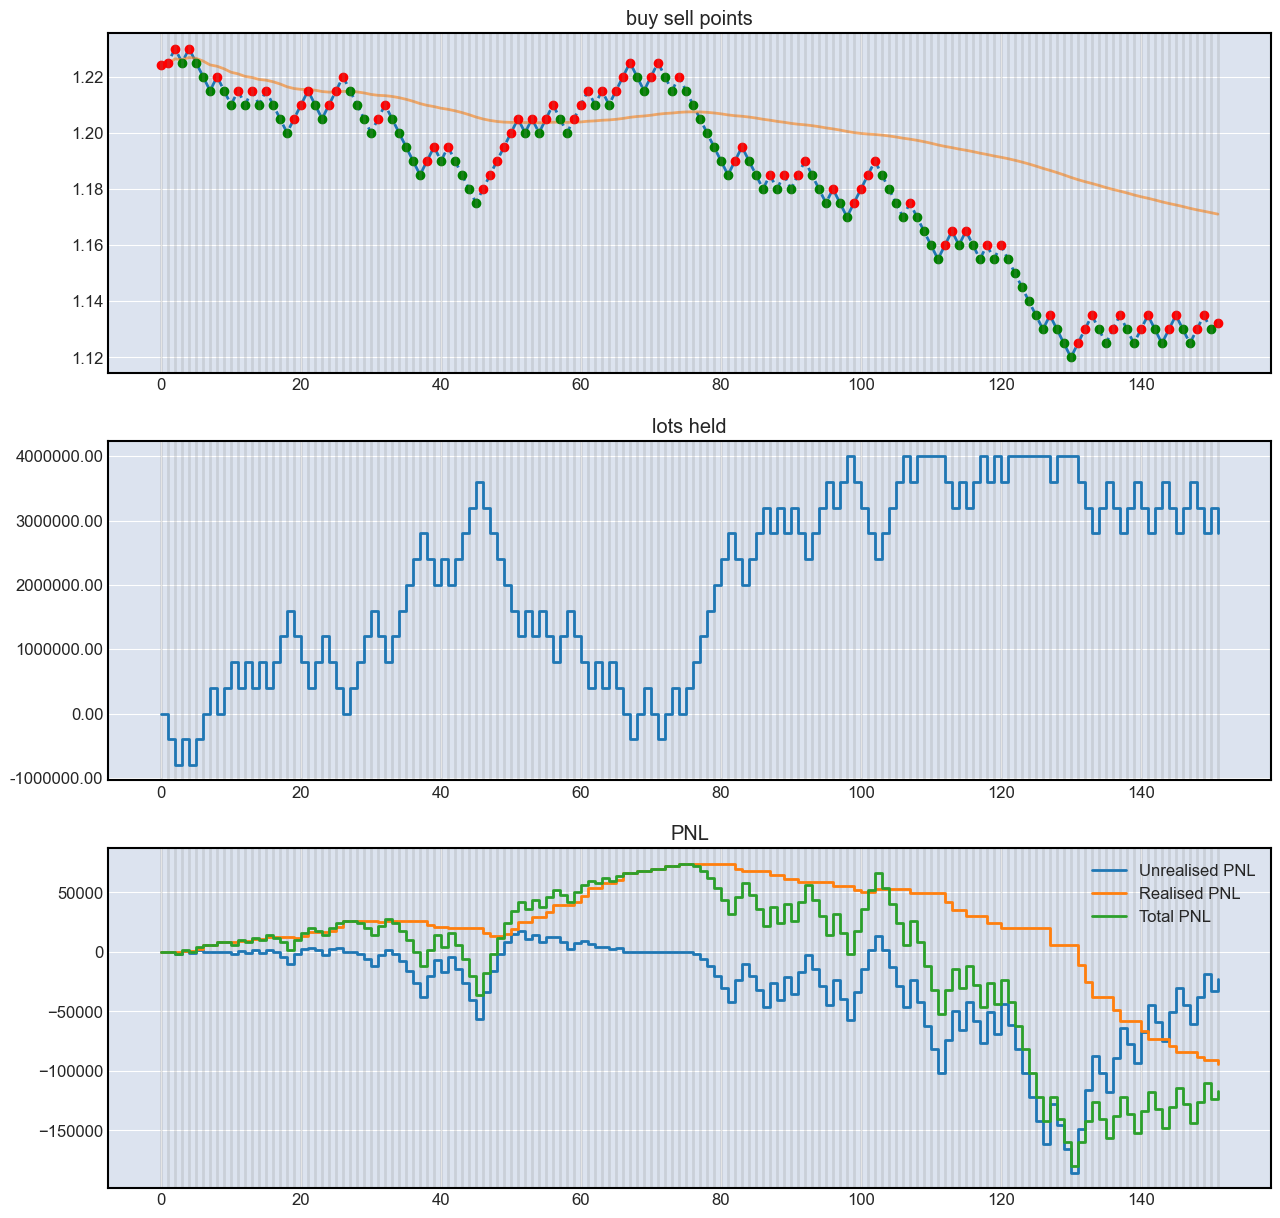

(array([      0.,       0.,   -2000.,    2000.,       0.,    4000.,
          6000.,    6000.,    8000.,    8000.,    6000.,   10000.,
          8000.,   12000.,   10000.,   14000.,   12000.,    8000.,
          2000.,   10000.,   16000.,   20000.,   18000.,   14000.,
         20000.,   24000.,   26000.,   26000.,   24000.,   20000.,
         14000.,   22000.,   28000.,   24000.,   18000.,   10000.,
            -0.,  -12000.,    2000.,   14000.,    4000.,   16000.,
          6000.,   -6000.,  -20000.,  -36000.,  -18000.,   -2000.,
         12000.,   24000.,   34000.,   42000.,   36000.,   44000.,
         38000.,   46000.,   52000.,   48000.,   42000.,   50000.,
         56000.,   60000.,   58000.,   62000.,   60000.,   64000.,
         66000.,   66000.,   68000.,   68000.,   70000.,   70000.,
         72000.,   72000.,   74000.,   74000.,   72000.,   68000.,
         62000.,   54000.,   44000.,   32000.,   46000.,   58000.,
         48000.,   36000.,   22000.,   38000.,   24000.,   40

In [130]:
#print(run_strategy_optimised(tick_data,grid_sizing=0.005,lot_sizing=400000))
time1 = time.time()
print(run_strategy_eval(tick_data,grid_sizing=0.005,lot_sizing=400000,trade_plot=True,ladder_function=ladderize_absolute_optimised))
time2 = time.time()
print(run_strategy_eval(tick_data,grid_sizing=0.005,lot_sizing=400000,trade_plot=True,ladder_function=ladderize_absolute))
time3 = time.time()
print('time for optimised: ',time2-time1)
print('time for non optimised: ',time3-time2)